In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, models

In [13]:
vgg = models.vgg19(pretrained=True).features.to(device)
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [14]:
for param in vgg.parameters():
    param.requires_grad_(False)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
def image2tensor(path, max_size=400, shape=None):
    image = Image.open(path).convert('RGB')
    if max(image.size)>max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape
    img_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))
    ])
    #as pil has rgba channels so removing the 'a' channel and adding the batch dimension.
    image = img_transform(image)[:3, :, :].unsqueeze(0)
    return image

In [40]:
content = image2tensor('images/octopus.jpg').to(device)
style = image2tensor('images/kahlo.jpg').to(device)

In [41]:
def tensor2image(tensor):
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

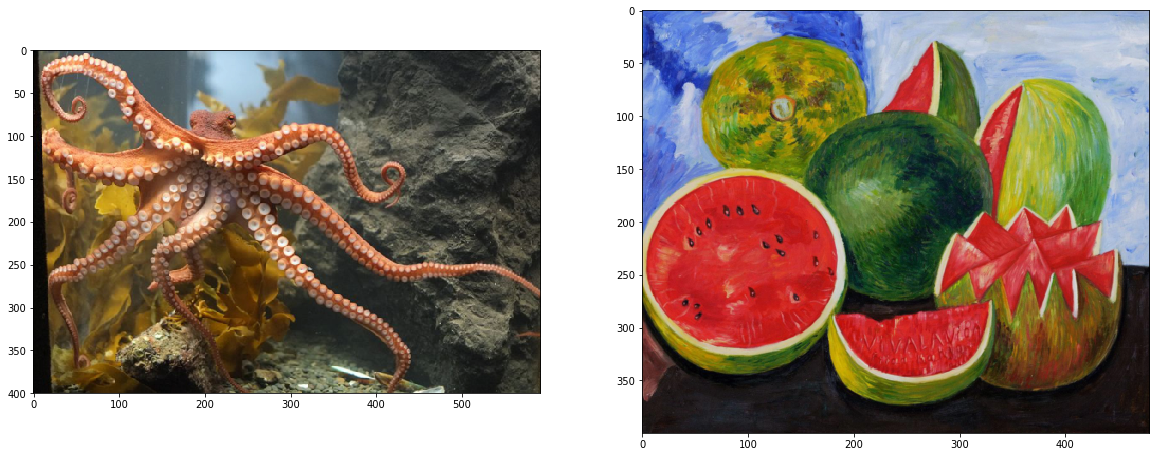

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(tensor2image(content))
ax2.imshow(tensor2image(style))

In [43]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
    x = image
    features = {}
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [44]:
def gram_matrix(tensor):
    _, d, w, h = tensor.shape
    x = tensor.view(d, w*h)
    gram = torch.mm(x, x.t())
    return gram

In [45]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
target = content.clone().requires_grad_(True).to(device)

In [46]:
style_weights = {'conv1_1': 1, 
                 'conv2_1': 0.8,
                 'conv3_1': 0.5, 
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}
content_weight = 1
style_weight = 1e6

Total loss 10273637.0


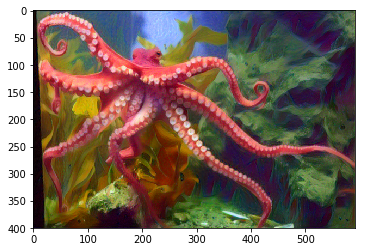

Total loss 3834440.5


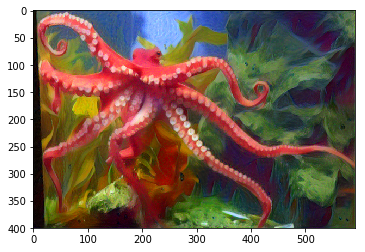

Total loss 2389668.0


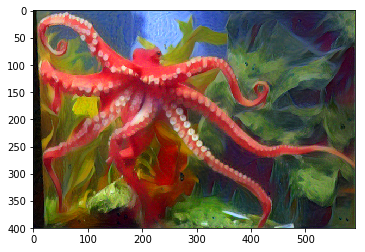

Total loss 1734706.875


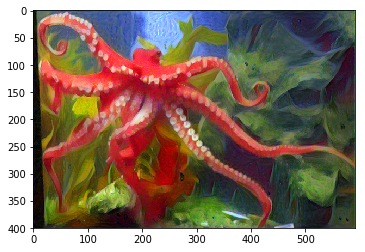

Total loss 1369908.375


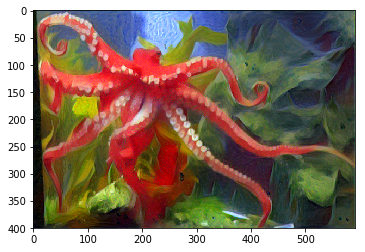

In [47]:
show_every = 400
optimizer = torch.optim.Adam([target], lr=0.003)
steps = 2000
for i in range(1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2']-content_features['conv4_2'])**2)
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer]*torch.mean((target_gram-style_gram)**2)
        style_loss+=layer_style_loss/(d*h*w)
    total_loss = content_weight*content_loss + style_weight*style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    if i%show_every==0:
        print('Total loss', total_loss.item())
        plt.imshow(tensor2image(target))
        plt.show()

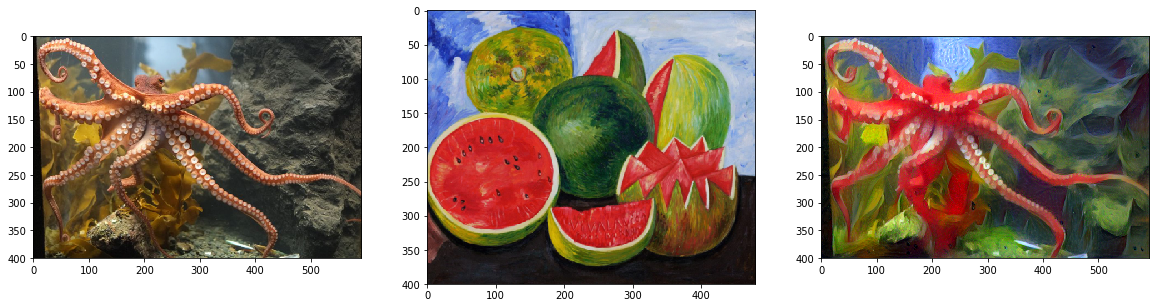

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(tensor2image(content))
ax2.imshow(tensor2image(style))
ax3.imshow(tensor2image(target))